In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from iqa_interpolator import IQA_Interpolator 

In [2]:
reports = []
for i in range(1,9):
    reports.append(pd.read_excel(f'relatorios/relatorio{i}.xlsx', decimal=','))
df = pd.concat(reports)
df['Data Coleta'] = pd.to_datetime(df['Data Coleta'], format='%d/%m/%Y')
df.head()

,Período DE,Período ATE,Cod_Interaguas,Tipo Rede,UGRHI,Código Ponto,Status Ponto,Data Coleta,Hora Coleta,Parametro,...,CLASSE,Município,UF,Inicio Operação,Fim Operação,Latitude,Longitude,Altitude,Localização,Captação
0,01/01/2001,01/01/2006,116,Rede Básica,06 - ALTO TIÊTE,TIET04150,Ativo,2001-01-11,09:25,Coliformes Termotolerantes,...,Classe 4,GUARULHOS,SP,01/01/1976,NaN,23 28 36,46 29 59,700,"Ponte na Rod. Ayrton Senna, a montante do Parq...",N
1,01/01/2001,01/01/2006,116,Rede Básica,06 - ALTO TIÊTE,TIET04150,Ativo,2001-03-27,10:25,Coliformes Termotolerantes,...,Classe 4,GUARULHOS,SP,01/01/1976,NaN,23 28 36,46 29 59,700,"Ponte na Rod. Ayrton Senna, a montante do Parq...",N
2,01/01/2001,01/01/2006,116,Rede Básica,06 - ALTO TIÊTE,TIET04150,Ativo,2001-05-30,09:40,Coliformes Termotolerantes,...,Classe 4,GUARULHOS,SP,01/01/1976,NaN,23 28 36,46 29 59,700,"Ponte na Rod. Ayrton Senna, a montante do Parq...",N
3,01/01/2001,01/01/2006,116,Rede Básica,06 - ALTO TIÊTE,TIET04150,Ativo,2001-07-25,09:35,Coliformes Termotolerantes,...,Classe 4,GUARULHOS,SP,01/01/1976,NaN,23 28 36,46 29 59,700,"Ponte na Rod. Ayrton Senna, a montante do Parq...",N
4,01/01/2001,01/01/2006,116,Rede Básica,06 - ALTO TIÊTE,TIET04150,Ativo,2001-09-18,09:50,Coliformes Termotolerantes,...,Classe 4,GUARULHOS,SP,01/01/1976,NaN,23 28 36,46 29 59,700,"Ponte na Rod. Ayrton Senna, a montante do Parq...",N


In [3]:
print(df.columns)
print(df.Parametro.value_counts())

Index(['Período DE', 'Período ATE', 'Cod_Interaguas', 'Tipo Rede', 'UGRHI',
       'Código Ponto', 'Status Ponto', 'Data Coleta', 'Hora Coleta',
       'Parametro', 'Sinal', 'Valor', 'Unidade', 'Tipo Parâmetro',
       'Sistema Hídrico', 'Tipo de Sistema Hídrico', 'CLASSE', 'Município',
       'UF', 'Inicio Operação', 'Fim Operação', 'Latitude', 'Longitude',
       'Altitude', 'Localização', 'Captação'],
      dtype='object')
Manganês Total                             262
Nitrogênio Amoniacal                       262
Cloreto Total                              262
Fósforo Total                              262
Sólido Total                               262
Coloração                                  261
Chuvas nas últimas 24h                     261
Subst. Tensoat. reagem c/ Azul Metileno    261
pH                                         261
Temperatura da Água                        261
Nitrogênio-Nitrato                         260
Nitrogênio-Nitrito                         260
DBO (5

In [4]:
droppers = ['Cod_Interaguas', 'Tipo Rede', 'Código Ponto', 'Status Ponto', 'Hora Coleta', 'UGRHI', 'Município', 'UF', 'CLASSE', 'Sistema Hídrico', 'Tipo de Sistema Hídrico', 'Localização', 'Captação', 'Altitude', 'Latitude', 'Longitude', 'Inicio Operação', 'Fim Operação']
parametrosRelevantes = ['pH', 'Temperatura da Água', 'Sólido Dissolvido Total', 'Oxigênio Dissolvido', 'Turbidez', 'Nitrogênio-Nitrito', 'Nitrogênio-Nitrato', 'Nitrogênio Amoniacal', 'Fósforo Total', 'DBO (5, 20)', 'Coliformes Termotolerantes']
dfFiltered = df.drop(droppers, axis=1)
dfParameters = dfFiltered[dfFiltered['Parametro'].isin(parametrosRelevantes)].reset_index() 
dfParameters.sort_values(by='Data Coleta', inplace=True)

In [5]:
parametersDfs={}

for parameter in parametrosRelevantes:
    parametersDfs[parameter] = dfParameters[dfParameters['Parametro']==parameter].reset_index()
    if parameter != 'Coloração':
        parametersDfs[parameter]['Valor'] = pd.to_numeric(parametersDfs[parameter]['Valor']) 


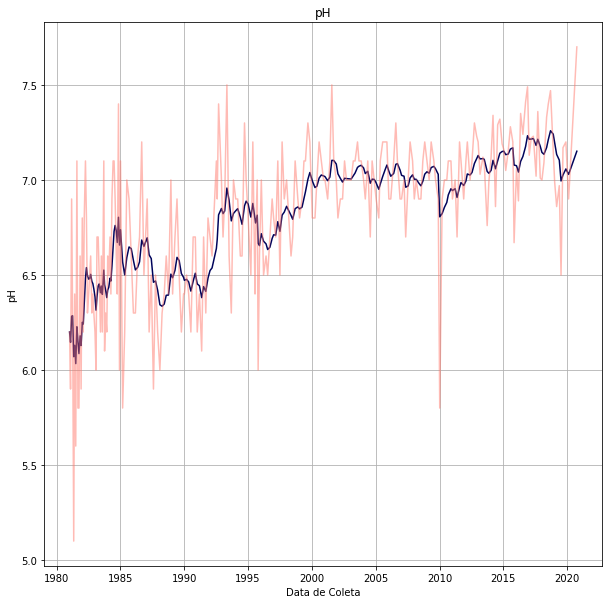

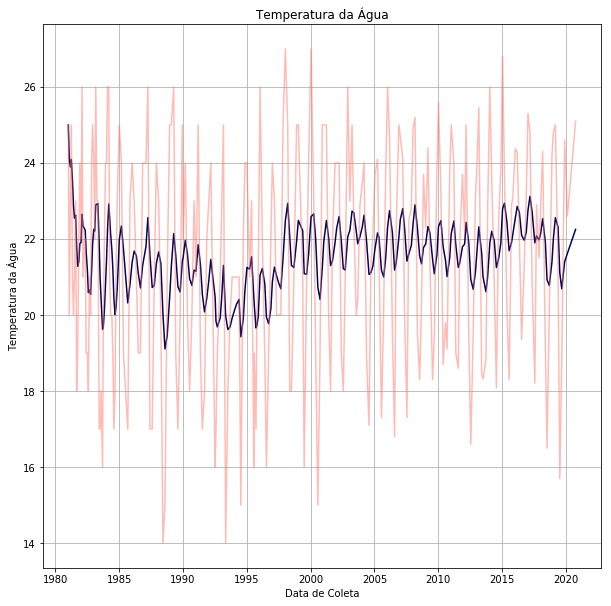

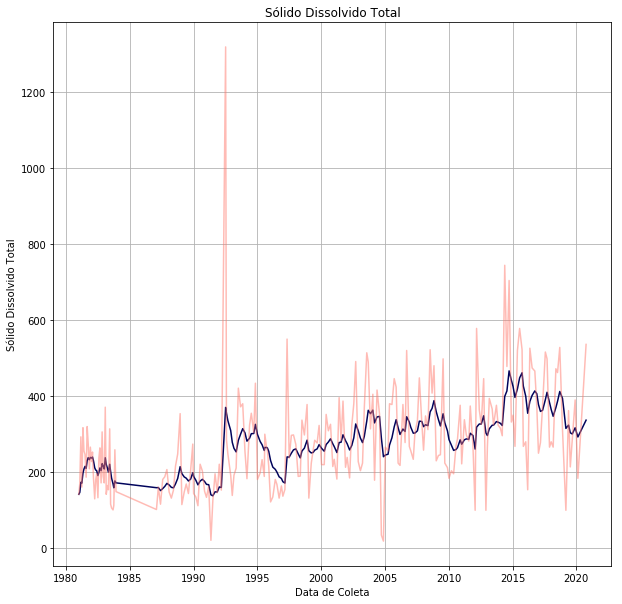

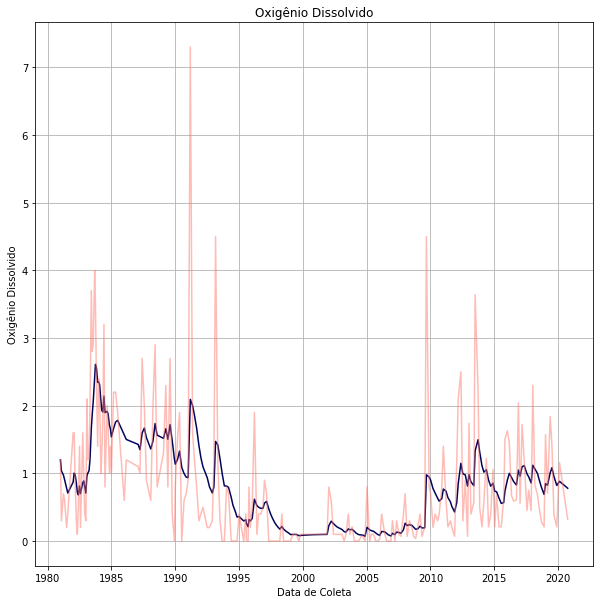

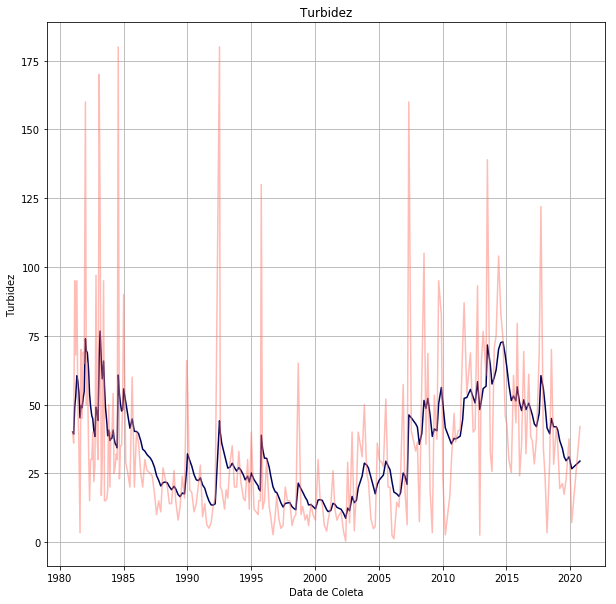

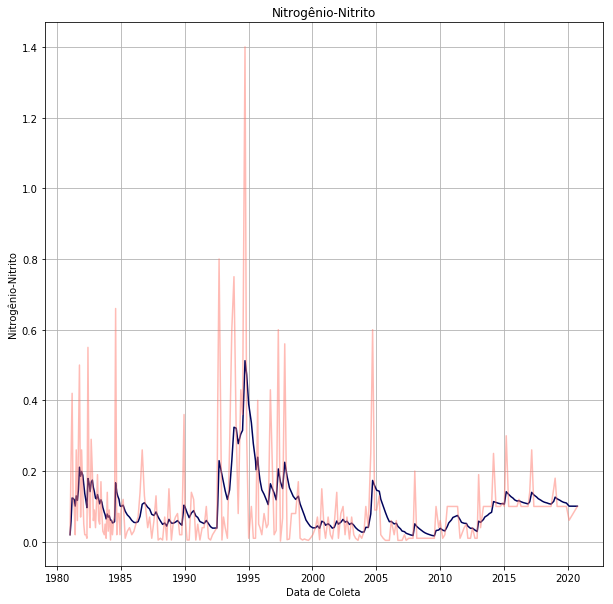

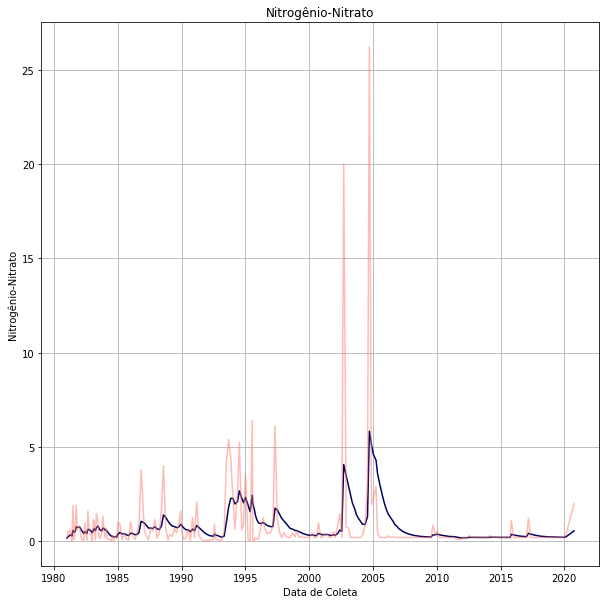

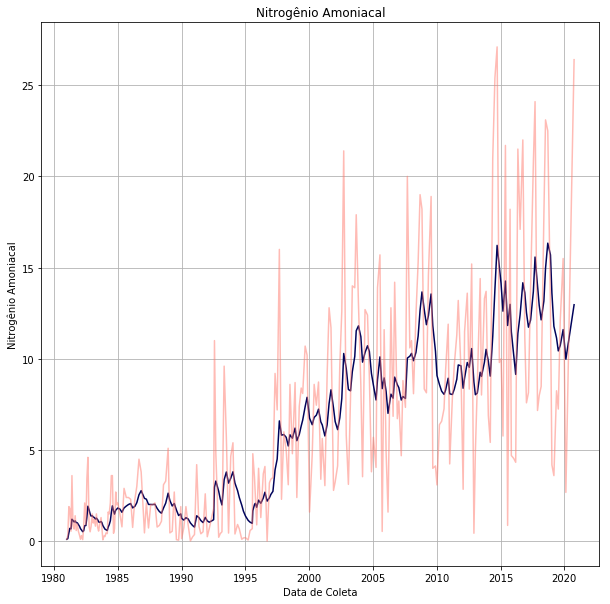

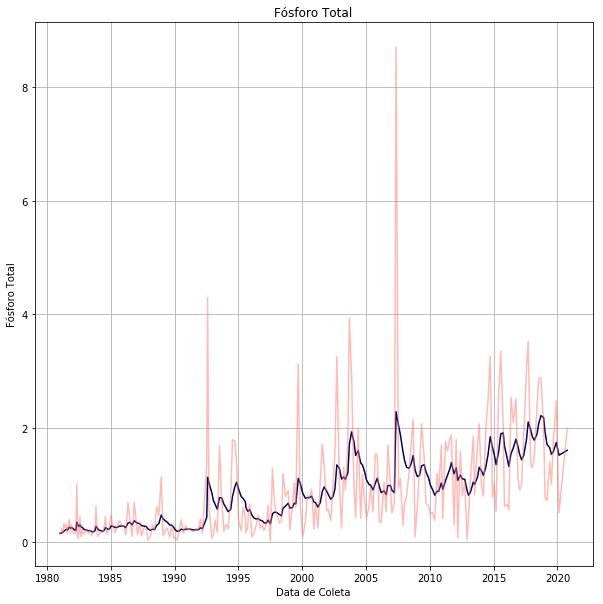

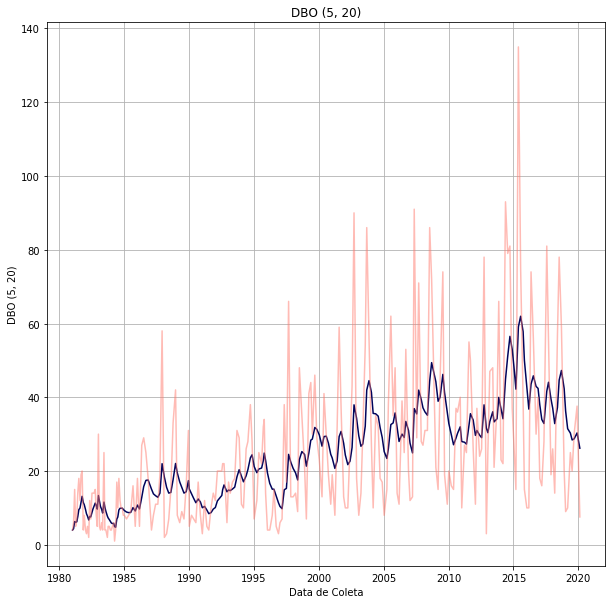

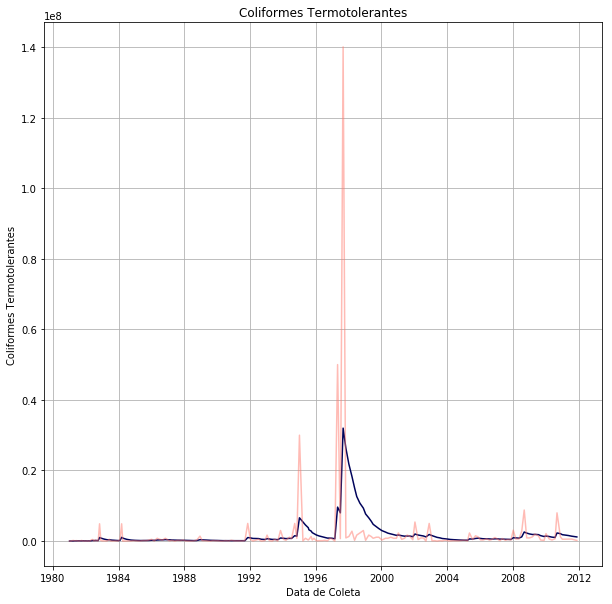

In [6]:
i = 0
for parameter in parametrosRelevantes:
    if parameter != 'Coloração':
        serie = parametersDfs[parameter]
        serieValor = serie['Valor'].ewm(span=10, adjust=False).mean()
        serieValorRaw = serie['Valor']
        plt.figure(figsize=(10,10))
        plt.grid(True)
        plt.plot(serie['Data Coleta'], serieValor, c='#00035b')
        plt.plot(serie['Data Coleta'], serieValorRaw, c='#ff796c', alpha=0.5)
        plt.title(parameter)
        plt.xlabel("Data de Coleta")
        plt.ylabel(parameter)
        plt.savefig(f'plots/{i}.png')
        i += 1

In [7]:
IQA_Dictionary = {'Coliformes Termotolerantes':5,'pH':7,'DBO (5, 20)':2, 'Temperatura da Água':25, 'Turbidez':10, 'Nitrogênio-Nitrato':0, 'Fósforo Total': 0, 'Sólido Dissolvido Total': 50, 'Oxigênio Dissolvido':100}

In [8]:
lista = list(dfParameters['Data Coleta'])
listaUnica = []
for data in lista:
    if data not in listaUnica:
        listaUnica.append(data)

In [9]:
primeiraColeta = dfParameters[dfParameters['Data Coleta'] == listaUnica[0]]
for key in IQA_Dictionary.keys():
    IQA_Dictionary[key] = float(pd.to_numeric(primeiraColeta[primeiraColeta['Parametro']==key]['Valor']))


In [10]:
Interpolator = IQA_Interpolator()


In [31]:
IQATimeline = {}
for data in listaUnica:
    coleta = dfParameters[dfParameters['Data Coleta'] == data]
    for key in IQA_Dictionary.keys():
        if key in list(coleta['Parametro']):
            IQA_Dictionary[key] = float(pd.to_numeric(coleta[coleta['Parametro'] == key]['Valor']))
    IQA = Interpolator.IQA_Result(IQA_Dictionary)
    IQATimeline[data] = IQA



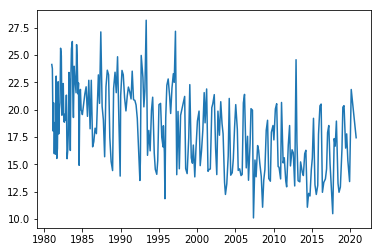

In [32]:
plt.plot(IQATimeline.keys(), IQATimeline.values())
plt.show()